# Prediction of Key Variables in Wastewater Treatment Plants Using Machine Learning Models

## Case Studies - Transformer Algorithm

## Notebook developed for WCCI paper case study: <p style="color:blue">Total suspended solids (TSS).</p>

## Data source: Benchmark Simulation Model No 2 - BSM2

## Objective: 
Predict TSS value at the exit of the primary clarifier

## Initial Exploratory Data Analysis

The initial exploratory analysis was performed on the main notebook for the case study.

In [2]:
# Load required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.6.0


In [4]:
# Load datasets in csv: data at the entrance and exit of the primary clarifier
df_entrada = pd.read_csv('datasets/df_entrada.csv')
df_saida = pd.read_csv('datasets/df_saida.csv')

In [6]:
# Copy the TSS column from the df_saida table to a target column, and add it to the df_entrada table
df_entrada['TSS_target'] = df_saida['TSS']

In [7]:
# Dataset created
df_entrada.head()

,time (d),S_I,S_S,X_I,X_S,"X_B,H","X_B,A",X_P,S_O,S_NO,S_NH,S_ND,X_ND,S_ALK,TSS,Flow_rate,Temp,TSS_target
0,0.000000,28.066969,59.047313,94.355715,356.843407,50.894638,0.094638,0.653099,0.017547,0.117359,34.921458,5.545698,15.813178,7.696519,377.131123,21086.383772,14.858080,197.191670
1,0.010417,30.359420,44.060564,98.451711,403.466911,54.971138,0.131598,0.873977,0.024448,0.163515,34.337683,5.882904,12.754084,7.733646,418.421501,15136.796894,15.133197,200.056489
2,0.020833,30.603369,42.103457,97.134587,398.790339,54.515963,0.135572,0.897778,0.025447,0.170197,33.788222,5.796989,12.299091,7.737372,413.605679,14558.437403,15.104875,201.682964
3,0.031250,30.767243,40.836855,96.364946,395.681291,54.445814,0.140303,0.926121,0.026709,0.178608,33.347855,5.754190,12.046154,7.741579,410.668856,13892.458337,15.075487,202.443577
4,0.041667,30.892948,39.920278,95.873859,393.245228,54.560720,0.145232,0.955677,0.028096,0.187699,32.953289,5.739111,11.888264,7.745834,408.585538,13239.722803,15.045215,202.608927


## Split data into training and testing sets

In [8]:
df_treino = df_entrada[0:17280] # 180 days for training and testing
df_teste_final = df_entrada[34936:36001] # 10 days (holdout sample) for final test

In [9]:
# Adjust graph size
sns.set(rc={'figure.figsize':(15,8)})

<AxesSubplot:xlabel='time (d)', ylabel='TSS_target'>

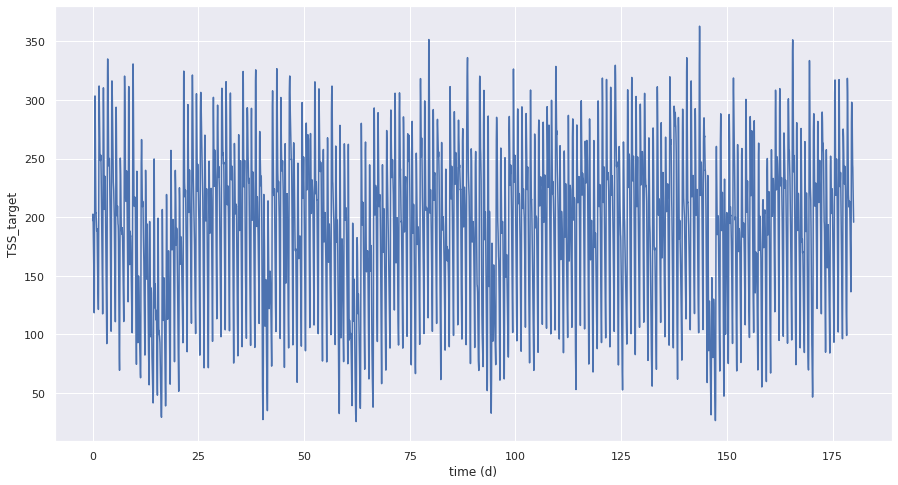

In [10]:
# 180 days for training and testing
sns.lineplot(x="time (d)", y="TSS_target", data=df_treino)

<AxesSubplot:xlabel='time (d)', ylabel='TSS_target'>

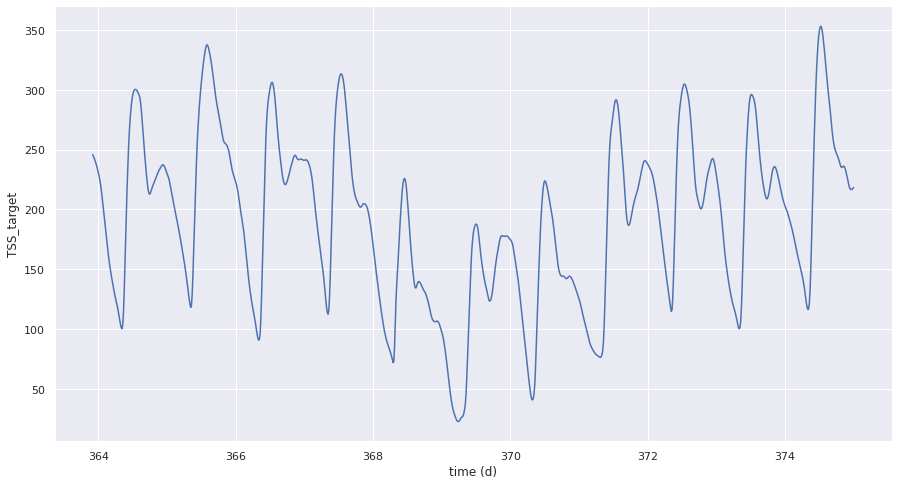

In [11]:
# 10 days for final evaluation
sns.lineplot(x="time (d)", y="TSS_target", data=df_teste_final)

## Algorithms: Transformers

In [44]:
df1 = df_entrada.filter(['S_I', 'S_NH', 'X_ND', 'TSS_target', 'TSS'], axis=1)

df = df1[0:17280] # 180 days for training and testing
val_data = df1[34744:36001] # 10 days (holdout sample) for final test

In [45]:
batch_size = 32
seq_len = 96
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [46]:
# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scalerT = scaler.fit(df)
train_data = scalerT.transform(df)

In [47]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i]) 
    y_train.append(train_data[:, 3][i]) 
X_train, y_train = np.array(X_train), np.array(y_train)

In [48]:
# Normalize Validation data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scalerV = scaler.fit(val_data)
val_data = scalerV.transform(val_data)

In [49]:
# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

In [50]:
print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)

Training set shape (17184, 96, 5) (17184,)
Validation set shape (1161, 96, 5) (1161,)


In [21]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

In [22]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k, 
                         input_shape=input_shape, 
                         kernel_initializer='glorot_uniform', 
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out    

#############################################################################

class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  

        
        self.linear = Dense(input_shape[0][-1], 
                            input_shape=input_shape, 
                            kernel_initializer='glorot_uniform', 
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
         
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer 

    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config       

In [ ]:
# If the algorithm has already been created and trained, you don't need to run this part.

def create_model():
    # Initialize time and transformer layers
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    # Construct model
    in_seq = Input(shape=(seq_len, 5))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer_trolha2.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=40, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('Transformer_trolha2.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)


#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)

print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))


###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='TSS_target')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=1, label='TSS_target')
ax11.set_title("TSS_target", fontsize=18)
ax11.set_xlabel('TSS_target')
ax11.set_ylabel('TSS_target')
ax11.legend(loc="best", fontsize=12)

In [24]:
# Load the trained model

model = tf.keras.models.load_model('modelos/Transformer_trolha2.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

In [3]:
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_val)

#X_val, y_val
#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_val, y_val, verbose=0)

print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))


###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer", fontsize=22)
st.set_y(0.92)

# Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(val_data[:, 3], label='TSS_target')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=1, label='TSS_target')
ax11.set_title("TSS_target", fontsize=18)
ax11.set_xlabel('TSS_target')
ax11.set_ylabel('TSS_target')
ax11.legend(loc="best", fontsize=12)

In [52]:
# Make prediction with trained model
previsao_trans = model.predict(X_val)

In [53]:
# Copy scaler dimension to do inverse normalization
prediction_copies = np.repeat(previsao_trans , val_data.shape[1], axis=-1)
previstoT = scalerV.inverse_transform(prediction_copies)[:,3] # Predicted value

In [54]:
previstoT.shape

(1161,)

In [55]:
# Load data with original format
df1 = df_entrada.filter(['S_I', 'S_NH', 'X_ND', 'TSS_target', 'TSS'], axis=1)

df = df1[0:17280] 
val_data = df1[34840:36001] 

In [56]:
# Create dataframe with actual and forecast values
df2 = val_data.TSS_target
df2 = df2.reset_index(drop=True)

In [57]:
previstoTT1 = previstoT[0:1065]

In [58]:
# Transform forecast into dataframe
df_T = pd.DataFrame(previstoTT1, columns = ['previstoT'])

In [61]:
# Export created dataset
df_T.to_csv(r'datasets/previsão_transformer1.csv', index = False) 

In [59]:
df22 = df2[10:1066]

In [4]:
# TSS graph
plt.figure(figsize = (15, 6))
plt.plot(df22) 
plt.plot(previstoTT1) # em verde 
plt.title('Transformers', family='Arial', fontsize=14)
plt.xlabel('Samples(15 minutes)')
plt.ylabel('TSS value')
plt.legend(['Real value', 'Predicted value'], loc='upper right')